In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud
import time
from datetime import datetime



In [2]:
#reading data & displaying first  5 rows and dimensions
naira_tweets = pd.read_csv('data/naira_tweets_cleaned.csv')
naira_tweets.head()

,date,tweet_id,text,user_name,invalid_date
0,2014-01-01,4.182154264603566e+17,Reduced Dollar Sales weakens the Naira -,Liveinnaija,no
1,2014-01-01,4.18275811922559e+17,"""And today .. 170 Naira to the US dollar .. Sa...",thisisdamola,no
2,2014-01-01,4.183338053056635e+17,This dollar naira exchange rate is not helping...,MarcoVanBalden,no
3,2014-01-01,4.183527745194762e+17,2014 will be your own turn to make clean Milli...,NuolEstates,no
4,2014-01-01,4.184154858612613e+17,"""@doLLaR_pEE017: Chelsea abeg no dull me ooo""n...",DjSix7Even,no


In [3]:
#function to find invalid dates
def find_invalid_dates (string):
    if string[:4] not in str([2014, 2015, 2016, 2017, 2018, 2019, 2020]):
        return "yes"
    else:
        return "no"
    

In [4]:
#mapping function to dataframe to ensure there are no invalid dates
naira_tweets['invalid_date'] = naira_tweets.apply(lambda x:find_invalid_dates(x['date']),axis =1)
naira_tweets.head()

,date,tweet_id,text,user_name,invalid_date
0,2014-01-01,4.182154264603566e+17,Reduced Dollar Sales weakens the Naira -,Liveinnaija,no
1,2014-01-01,4.18275811922559e+17,"""And today .. 170 Naira to the US dollar .. Sa...",thisisdamola,no
2,2014-01-01,4.183338053056635e+17,This dollar naira exchange rate is not helping...,MarcoVanBalden,no
3,2014-01-01,4.183527745194762e+17,2014 will be your own turn to make clean Milli...,NuolEstates,no
4,2014-01-01,4.184154858612613e+17,"""@doLLaR_pEE017: Chelsea abeg no dull me ooo""n...",DjSix7Even,no


In [5]:
naira_tweets.drop(naira_tweets[naira_tweets['invalid_date'] =='yes'].index,inplace=True)

In [6]:
#change date column to datetime object
naira_tweets['date'] = pd.to_datetime(naira_tweets['date'])

#set date as index
naira_tweets.set_index('date', inplace = True)
display(naira_tweets.head())
display(naira_tweets.shape)

,tweet_id,text,user_name,invalid_date
date,,,,
2014-01-01,4.182154264603566e+17,Reduced Dollar Sales weakens the Naira -,Liveinnaija,no
2014-01-01,4.18275811922559e+17,"""And today .. 170 Naira to the US dollar .. Sa...",thisisdamola,no
2014-01-01,4.183338053056635e+17,This dollar naira exchange rate is not helping...,MarcoVanBalden,no
2014-01-01,4.183527745194762e+17,2014 will be your own turn to make clean Milli...,NuolEstates,no
2014-01-01,4.184154858612613e+17,"""@doLLaR_pEE017: Chelsea abeg no dull me ooo""n...",DjSix7Even,no


(116329, 4)

In [7]:
#checking data types
naira_tweets.dtypes

tweet_id        object
text            object
user_name       object
invalid_date    object
dtype: object

In [8]:
#reading data & displaying first 5 rows 
bdc_rates = pd.read_csv('data/bdc_rates_cleaned.csv')
display(bdc_rates.head())
display(bdc_rates.shape)

,date,nominal,bdc
0,2014-01-02,157.26,172.0
1,2014-01-03,157.26,172.0
2,2014-01-06,157.28,172.0
3,2014-01-07,157.28,172.0
4,2014-01-08,157.28,172.0


(1732, 3)

In [9]:
#checking info 
bdc_rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732 entries, 0 to 1731
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     1732 non-null   object 
 1   nominal  1732 non-null   float64
 2   bdc      1732 non-null   float64
dtypes: float64(2), object(1)
memory usage: 40.7+ KB


In [10]:
#date to datetime format and setting as index
bdc_rates.date = pd.to_datetime(bdc_rates.date)
bdc_rates.set_index('date', inplace = True)

In [11]:
#setting display options 
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 3000)
pd.set_option("display.max_columns", 3000)

## Naira Tweets

In [12]:
#creating column for word count
naira_tweets['word_count']= naira_tweets['text'].apply(lambda x: len(x.split()))
naira_tweets.head()

,tweet_id,text,user_name,invalid_date,word_count
date,,,,,
2014-01-01,4.182154264603566e+17,Reduced Dollar Sales weakens the Naira -,Liveinnaija,no,7
2014-01-01,4.18275811922559e+17,"""And today .. 170 Naira to the US dollar .. Sad !! @AfricaFactsZone: In 1980, Nigeria exchanged at 78 kobo to the US dollar.""",thisisdamola,no,24
2014-01-01,4.183338053056635e+17,This dollar naira exchange rate is not helping matters at all…,MarcoVanBalden,no,11
2014-01-01,4.183527745194762e+17,"2014 will be your own turn to make clean Millions of Money in Naira, Dollar, Pounds and Euro by God's special Grace. Femi Ayinuola &amp; Family",NuolEstates,no,26
2014-01-01,4.184154858612613e+17,"""@doLLaR_pEE017: Chelsea abeg no dull me ooo""naira bet this new year loool",DjSix7Even,no,12


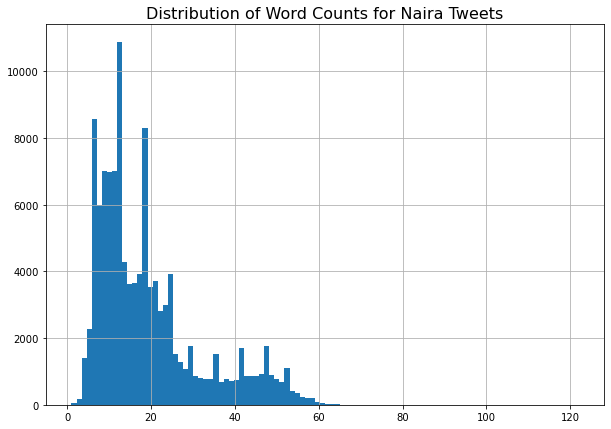

In [13]:
plt.figure(figsize=(10,7))
naira_tweets['word_count'].hist(bins=100)
plt.title("Distribution of Word Counts for Naira Tweets", fontsize=16)
plt.savefig("images/Distribution of Word Counts for Naira Tweets");

In 2017 (the midpoint of the time period considered in this study), twitter doubled its character limit from 140 characters (20 - 40 words) to 280 characters. Thus, the distribution observed in the figure about is expected. Interestingly though, the plot is skewed to the left, implying that even with the character limit increase, tweets which mentioned "naira value" contained fewer words on average.

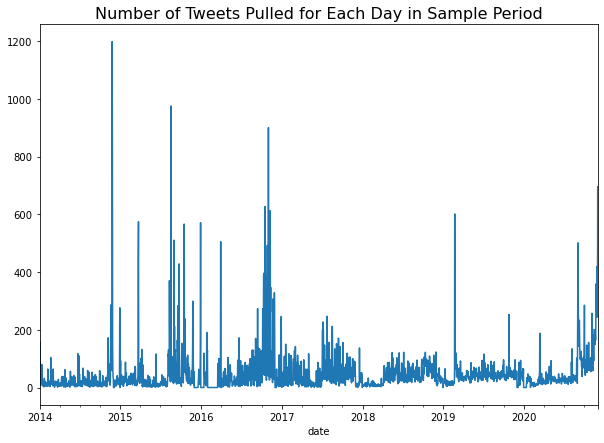

In [14]:
plt.figure(figsize=(10,7))

naira_tweets['text'].resample('D').count().plot()
plt.title("Number of Tweets Pulled for Each Day in Sample Period", fontsize=16)
plt.savefig("images/Number of Tweets Pulled for Each Day in Sample Period");

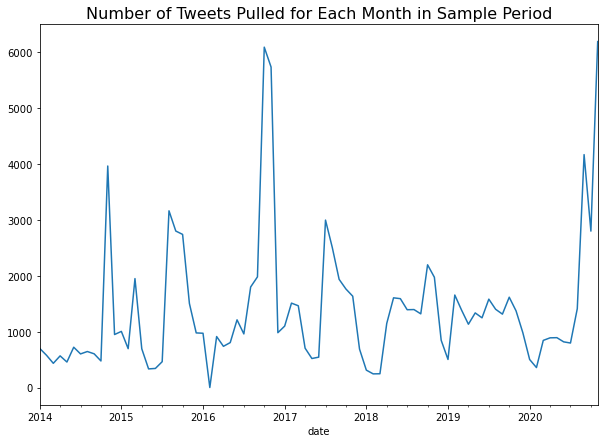

In [15]:
plt.figure(figsize=(10,7))

naira_tweets['text'].resample('M').count().plot()
plt.title("Number of Tweets Pulled for Each Month in Sample Period", fontsize=16)
plt.savefig("images/Number of Tweets Pulled for Each Month in Sample Period");

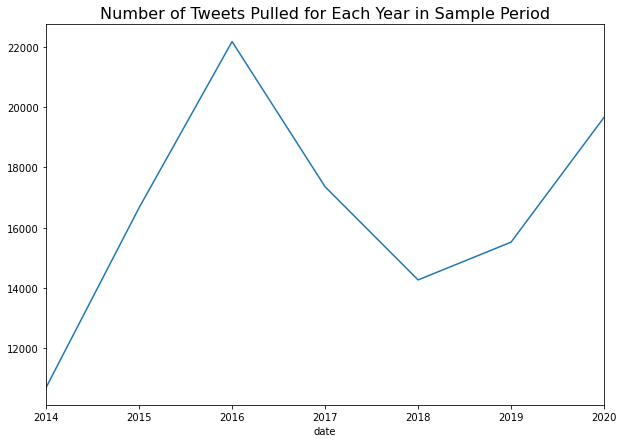

In [16]:
plt.figure(figsize=(10,7))

naira_tweets['text'].resample('Y').count().plot()
plt.title("Number of Tweets Pulled for Each Year in Sample Period", fontsize=16)
plt.savefig("images/Number of Tweets Pulled for Each Year in Sample Period");

###  Term Frequency - Inverse Document Frequency (TF-IDF) Vectorizer

TF-IDF is a score that tells us which words are important to one document, relative to all other documents. Words that occur often in one document but don't occur in many documents contain more predictive power.

In [17]:
#defining X1 variable
X1 = naira_tweets['text']

In [18]:
# Instantiate Vectorizer for text column with params
tvec = TfidfVectorizer(stop_words= 'english',ngram_range=(1,6),max_df=0.8,min_df=0.02)

#fit TFIDF vectorizer
X1_tvec = tvec.fit_transform(X1)

#store in dataframe
X1_tvec_df = pd.DataFrame(X1_tvec.todense(), columns= tvec.get_feature_names())

#display first 5 rows and dimensions of dataframe
display(X1_tvec_df.head())
display(X1_tvec_df.shape)

,amp,appreciates,appreciates dollar,bank,black,black market,buhari,cbn,currency,current,current value,depreciates,dollar,dollar naira,dollar parallel,dollar parallel market,dollars,don,economy,equal,euro,exchange,exchange rate,falls,gains,just,know,latest,like,make,market,money,naira appreciates,naira appreciates dollar,naira depreciates,naira dollar,naira exchange,naira exchange rate,naira value,new,news,nigeria,nigerian,nigerian naira,parallel,parallel market,people,pound,price,rate,rate dollar,rates,time,today,value,value naira
0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.422712,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.514758,0.000000,0.000000,0.0,0.0,0.0,0.511296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.543061,0.0,0.0
2,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.148703,0.378014,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.350764,0.379835,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.470331,0.480482,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.340012,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.47964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.147524,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.457663,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.449678,0.0,0.455438,0.0,0.0,0.0,0.359295,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0


(116329, 56)

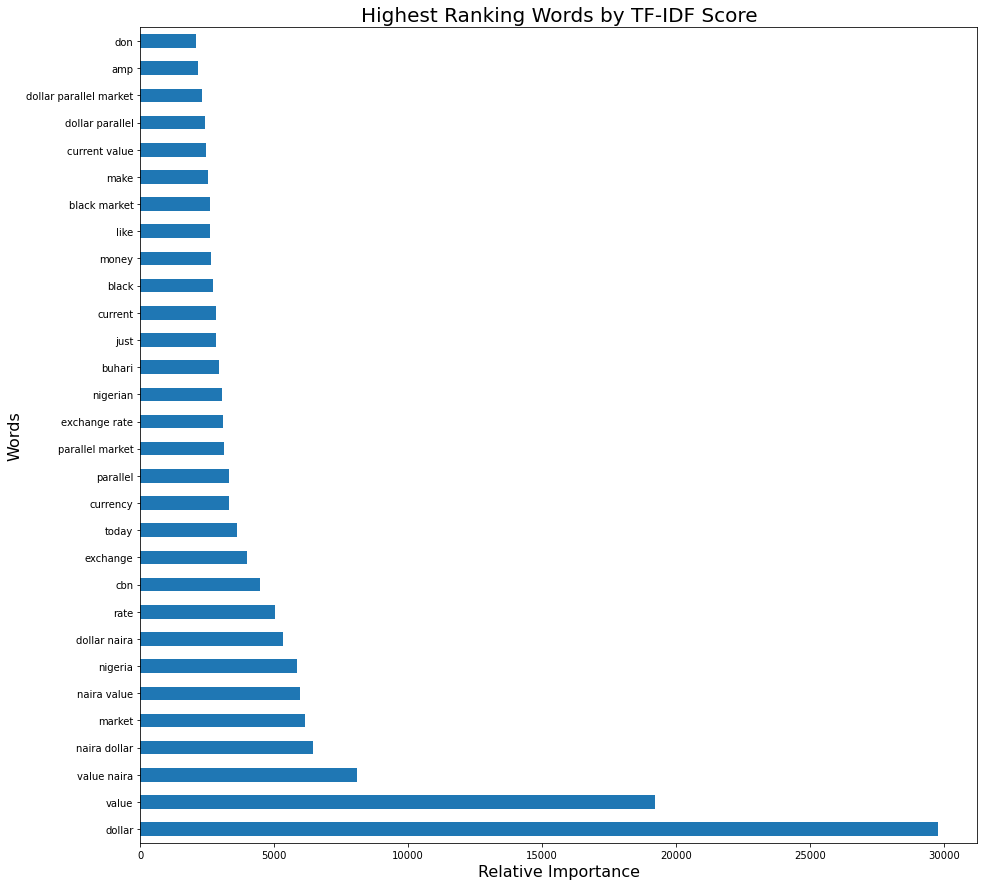

In [19]:
plt.figure(figsize=(15,15))
X1_tvec_df.sum().sort_values(ascending=False).head(30).plot(kind='barh')
plt.xlabel("Relative Importance",fontsize=16)
plt.ylabel("Words",fontsize=16)
plt.title("Highest Ranking Words by TF-IDF Score", fontsize=20)
plt.savefig("images/Highest Ranking Words by TF-IDF Score");

From the above, it is clear that there is need to remove stop words to improve the performance of the vectorizer.

In [20]:
#creating list of custom stop words
my_words = ['dollar', 'dollars', 'pound','pounds','euro','euros','10','value','naira','nigeria','rate','market','exchange','currency','just','nigerian','money',
           'don','amp','know','like','make']

In [21]:
#Merging with list of english stop words
from sklearn.feature_extraction import text 
stop_words = text.ENGLISH_STOP_WORDS.union(my_words)
stop_words

frozenset({'10',
           'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'amp',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
      

In [22]:
# Re-Instantiate Vectorizer & overwrite dataframe
tvec2 = TfidfVectorizer(stop_words= stop_words,ngram_range=(1,6),max_df=0.9,min_df=0.02)

#fit TFIDF vectorizer
X1_tvec = tvec2.fit_transform(X1)

#store in dataframe
X1_tvec_df = pd.DataFrame(X1_tvec.todense(), columns= tvec2.get_feature_names())

#display first 5 rows and dimensions of dataframe
display(X1_tvec_df.head())
display(X1_tvec_df.shape)

,appreciates,bank,black,buhari,cbn,current,depreciates,economy,equal,falls,gains,latest,new,news,parallel,people,price,rates,time,today
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(116329, 20)

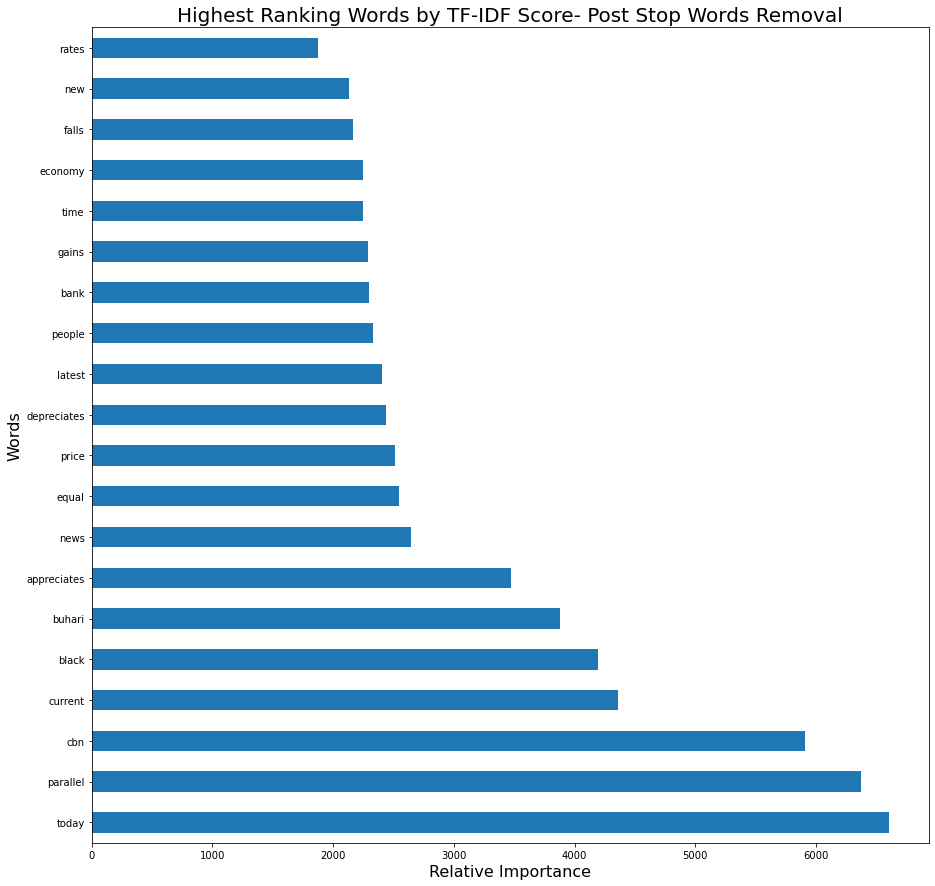

In [23]:
plt.figure(figsize=(15,15))
X1_tvec_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.xlabel("Relative Importance",fontsize=16)
plt.ylabel("Words",fontsize=16)
plt.title("Highest Ranking Words by TF-IDF Score- Post Stop Words Removal", fontsize=20)
plt.savefig("images/Highest Ranking Words by TF-IDF Score- Post Stop Words Removal");

In [24]:
#Prepping TFIDF Matrix for Word Cloud Creation
X1_tvec_df.T.sum(axis=1)

appreciates    3469.492538
bank           2294.607492
black          4194.702620
buhari         3881.399453
cbn            5907.300649
current        4361.930843
depreciates    2433.531616
economy        2244.044098
equal          2544.695897
falls          2165.069114
gains          2291.001049
latest         2405.764182
new            2132.388499
news           2643.572194
parallel       6371.494105
people         2333.434090
price          2513.205641
rates          1877.748587
time           2245.027151
today          6602.212688
dtype: float64

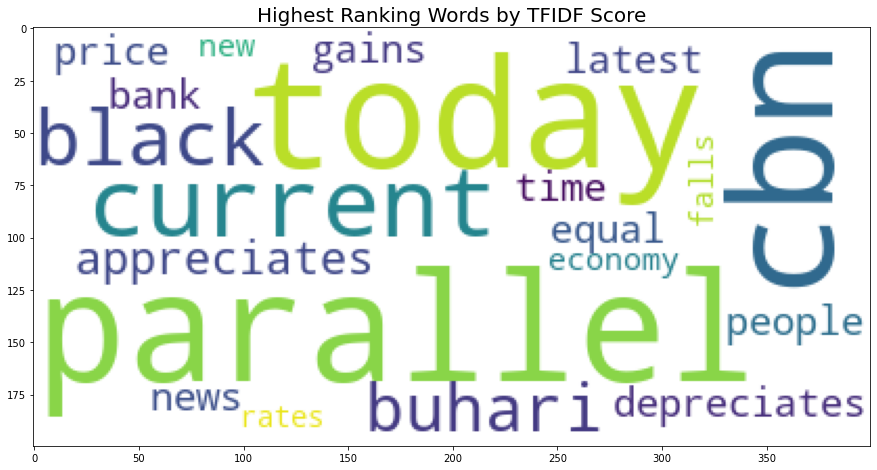

In [25]:
plt.figure(figsize=(15,10))
Cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(X1_tvec_df.T.sum(axis=1))

plt.imshow(Cloud)
plt.title("Highest Ranking Words by TFIDF Score", fontsize = 20 )
plt.savefig("images/Highest Ranking Words by TFIDF Score")

### Exploring Tweets 

In [26]:
naira_tweets[naira_tweets['text'].str.contains('today')].head()

,tweet_id,text,user_name,invalid_date,word_count
date,,,,,
2014-01-01,4.18275811922559e+17,"""And today .. 170 Naira to the US dollar .. Sad !! @AfricaFactsZone: In 1980, Nigeria exchanged at 78 kobo to the US dollar.""",thisisdamola,no,24
2014-01-08,4.2102354574207795e+17,"@abati1990 #LestWeForget.Dollar was 158 in the parallel mkt when GEJ took over,today it's 173 Naira@obyezeks @hbgumi @dino_melaye@omojuwa",shakaraOlojeni,no,17
2014-01-08,4.209806133999821e+17,If the value of 500 naira was a 100% twenty years ago. What would it be buying today. #shittytweet#,leggi007,no,19
2014-01-08,4.2099404060860006e+17,Pls what's the dollar exchange rate to naira today?,LanreAA,no,9
2014-01-09,4.212433546940539e+17,"Dollar to Naira RT @confessormissy: :s""@Mz_Chievous: From 172 just two days ago to 159 today""",Be_YouTeaFull,no,15


In [27]:
naira_tweets[naira_tweets['text'].str.contains('price')].tail()

,tweet_id,text,user_name,invalid_date,word_count
date,,,,,
2020-11-30,1.3335241594025533e+18,@MBuhari Everything about the country right now is pointing at death for it citizens the rich ain't all safe anymore\nMaybe you guys are(politicians)\nBut the price of a dollar to Nigeria's Naira is a gun on everyone's head,seawajNla,no,39
2020-11-30,1.3335283915811103e+18,"@kentuch005 aside insecurity hv U gone 2d mrkt recently? d prices of commodities are crazy. My Wife and Bro(s) would hv graduated did year but Asuu happened. ⛽, naira value, #EndSARS. The list is endless",AgbakuKingsley,no,35
2020-11-30,1.333502471461802e+18,"You dey save in naira to buy something wey the original price na in dollar, before you save finish, the price don double 😀. Chai !",yrr_HW,no,26
2020-11-30,1.3334851090565652e+18,Dollar-Naira rate today for black market was $1 -500naira yet you still priced foreign used Camry muscle to 1.8M ..My Brother..Fear God,Arthur_Toyosi,no,22
2020-11-30,1.3334726531061432e+18,"Sadly, is going to make a new high against many alt currencies including the naira. quote this tweet when it happens.\nI can't even say the price that comes to my head but try to buy if you can.",SeunKOlajide,no,39


In [28]:
naira_tweets[naira_tweets['text'].str.contains('buhari')].tail()

,tweet_id,text,user_name,invalid_date,word_count
date,,,,,
2020-11-30,1.3333164803064422e+18,"Had buhari not been president, by now he would have defeated insecurity, revived the economy, created fifty million jobs, and made naira equal to US dollar.",harrisonmbamara,no,26
2020-11-30,1.3335561847087677e+18,Before buhari leave office 1 dollar will be 1000 naira,ishaka_jibrin,no,10
2020-11-30,1.3335041650294907e+18,Can I pay 1 million naira? worry 1 million naira will be equal 1 million dollar -president buhari,Gracemonee,no,18
2020-11-30,1.3335040704773693e+18,@iceylamar @UnclePamilerin Can I pay 1 million naira? worry 1 million naira will be equal 1 million dollar -president buhari,Gracemonee,no,20
2020-11-30,1.3334721511528284e+18,Once upon a time!!!!🎶 The tell us say one dollar will be equal to one naira!!!! Once upon a time !!!!🎶 .buhari tell us one dollar equal to #140...but now everything na lying!!! Lying!!! 🎶 \nLai Mohammed is lying!!! Is lying.... Eeee 🎶,belovedtemmy,no,43


In [29]:
naira_tweets[naira_tweets['text'].str.contains('cbn')].tail()

,tweet_id,text,user_name,invalid_date,word_count
date,,,,,
2020-11-23,1.3309828993829683e+18,Half of cbn at a time when naira probably had more value than pounds? 😭😭😭😭 God why? UK economy fit crash if dem withdraw everything Nigerian from it niyen o,Hafi__z,no,30
2020-11-25,1.3315070223579914e+18,"I don’t even get, official dollar to naira rate according to cbn is around 380 per dollar but banks are using parallel market rates🥴",dejjjjjji,no,24
2020-11-26,1.3321037850454385e+18,@a4lahyan1 @HRH_onyx Half of cbn now is nothing compared to dollars with d way Dollar is going against naira not to talk of when them dey spend Kobo kobo,MichealOlajube,no,29
2020-11-28,1.3326900959047025e+18,"CBN devalues Naira, fixes dollar sale at N392 #cbn",nd_reporters,no,9
2020-11-28,1.332715935313113e+18,"Floating the naira doesn't immediately incentivize production increase in Naij. reason they're still propping it up.. feeling, real value somewhere in-between cbn and bdc rates. skyrocket immediately once floated due to panic but would settle..",toni_kroooz,no,35


In [30]:
naira_tweets[naira_tweets['text'].str.contains('equal')].head()

,tweet_id,text,user_name,invalid_date,word_count
date,,,,,
2014-01-07,4.204918805443584e+17,“@DirectorSolomon: Imagine a Nigeria where a girl will actually like me and say it... Via DM” one day. When Naira equals dollar I'm sure,litavalkyrie,no,24
2014-01-13,4.227329436192809e+17,My instant wish....announcement that N1 = $1....one naira should be equal to 1 dollar...lol,da_tesleem,no,14
2014-01-28,4.282167117296476e+17,1 American Dollar equals 171 Naira. Does it mean 1 American life equals 171 Nigerian lives? Cc. @omojuwa @toluogunlesi,segunOluwatoke,no,19
2014-02-04,4.308386019714089e+17,They say one Naira equals to one dollar.....once upon a time,_Maisaje,no,11
2014-02-15,4.346207253415895e+17,i wonder if one naira will equal a dollar ever again :(,Ms_Faivour,no,12


## Exchange Rate 

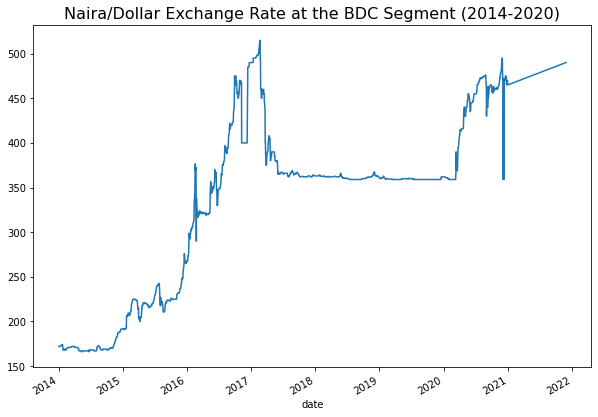

In [31]:
plt.figure(figsize=(10,7))

bdc_rates['bdc'].plot()
plt.title("Naira/Dollar Exchange Rate at the BDC Segment (2014-2020)", fontsize = 16)
plt.savefig ("images/Naira Dollar Exchange Rates at the BDC Segment")

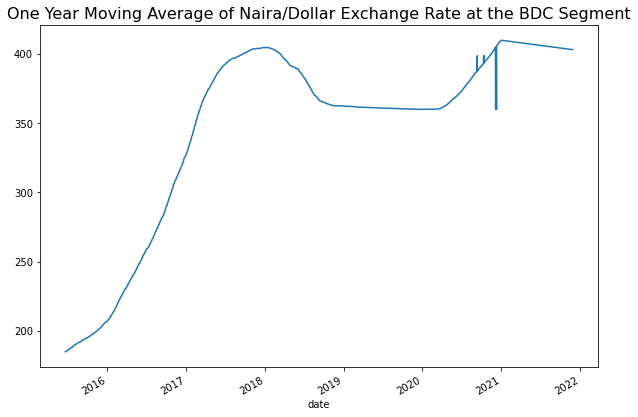

In [32]:
plt.figure(figsize=(10,7))

bdc_rates['bdc'].rolling(365).mean().plot()
plt.title("One Year Moving Average of Naira/Dollar Exchange Rate at the BDC Segment", fontsize = 16)
plt.savefig ("images/One Year Moving Average of Naira Dollar Exchange Rate Movements at the BDC Segment")

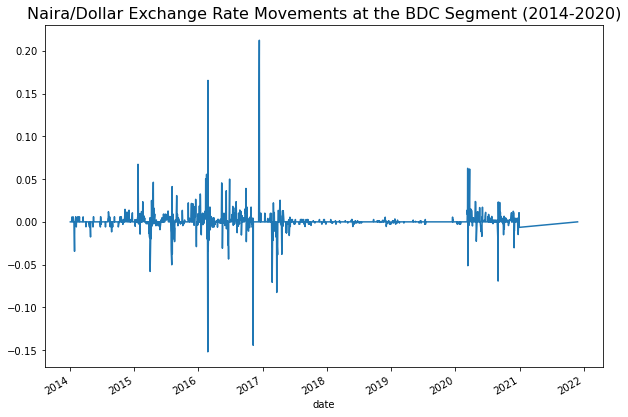

In [33]:
plt.figure(figsize=(10,7))

bdc_rates['bdc'].pct_change().plot()
plt.title("Naira/Dollar Exchange Rate Movements at the BDC Segment (2014-2020)", fontsize = 16)
plt.savefig ("images/Naira Dollar Exchange Rate Movements at the BDC Segment")

## Sentiment Analysis - VADER

In [34]:
#instantiating SIA
sia = SentimentIntensityAnalyzer()

In [35]:
#converting self text column to list of strings
corpus= list(naira_tweets['text'])

In [36]:
#creating dataframe which has SIA scores for each selftext
sentiment = []    

for tweet in corpus:
    scores = sia.polarity_scores(tweet)
    scores['text'] = tweet
    sentiment.append(scores)

naira_tweets_sent = pd.DataFrame(sentiment)
naira_tweets_sent.head()

,neg,neu,pos,compound,text
0,0.315,0.685,0.000,-0.3182,Reduced Dollar Sales weakens the Naira -
1,0.138,0.862,0.000,-0.5696,"""And today .. 170 Naira to the US dollar .. Sad !! @AfricaFactsZone: In 1980, Nigeria exchanged at 78 kobo to the US dollar."""
2,0.248,0.752,0.000,-0.2411,This dollar naira exchange rate is not helping matters at all…
3,0.000,0.737,0.263,0.8020,"2014 will be your own turn to make clean Millions of Money in Naira, Dollar, Pounds and Euro by God's special Grace. Femi Ayinuola &amp; Family"
4,0.329,0.671,0.000,-0.5994,"""@doLLaR_pEE017: Chelsea abeg no dull me ooo""naira bet this new year loool"


In [37]:
#viewing tweets with with very negative sentiments
naira_tweets_sent[naira_tweets_sent['compound'] <-0.5].head()

,neg,neu,pos,compound,text
1,0.138,0.862,0.000,-0.5696,"""And today .. 170 Naira to the US dollar .. Sad !! @AfricaFactsZone: In 1980, Nigeria exchanged at 78 kobo to the US dollar."""
4,0.329,0.671,0.000,-0.5994,"""@doLLaR_pEE017: Chelsea abeg no dull me ooo""naira bet this new year loool"
32,0.182,0.818,0.000,-0.5826,"Dia goes my cotonou plans :( ""@TubosunAkeju: “Dear Lord!!! @Mr_behankey: Nigeria’s Naira Currency Crashes To N173 Per Dollar."
165,0.330,0.512,0.158,-0.7482,That JP Morgan and co subprime fraud forced Naira value from 117 to to 150. A global crime @4eyedmonk @enginedare @toluogunlesi @Chxta
207,0.272,0.524,0.204,-0.5574,"Nig, ur enemies fall lik naira value, may u move freely like criminals in nig, may u nt fail lik PHCN, may ur prayers b acepted lik elec ..."


In [38]:
#viewing tweets with high positive sentiment scores
naira_tweets_sent[naira_tweets_sent['compound']>0.8]

,neg,neu,pos,compound,text
3,0.000,0.737,0.263,0.8020,"2014 will be your own turn to make clean Millions of Money in Naira, Dollar, Pounds and Euro by God's special Grace. Femi Ayinuola &amp; Family"
39,0.000,0.547,0.453,0.9118,Wow!!! So US Dollar to Naira is now 173 ... SWEET!!! Good sign for this year's hustle.
52,0.000,0.630,0.370,0.8555,"""@Sammychidoka: “@Bayodewande: @Sammychidoka yes in Lagos.” Wow, seems we will have a ""rainfull"" 2014""It better b NAIRA and DOLLAR RAIN oh"
331,0.000,0.580,0.420,0.8906,"""@ERNALBEAT: Loving it! Bt make dollar go up well well o jare!@weirdmcofficial: #Sighs 280 Naira to a pound.which way nigeria ..not good o"
343,0.000,0.633,0.367,0.8507,"Loving it!!! Bt make dollar go up well well o jare! ""@weirdmcofficial: #Sighs 280 Naira to a pound.. which way nigeria"""
...,...,...,...,...,...
116134,0.048,0.703,0.248,0.8442,@nderi_j Naira is trading much lower at 500 in the parallel market. Most of the policy measures taken including capital controls have been to defend the currency’s strength. Market should ideally freely determine the value of a currency.
116136,0.040,0.719,0.242,0.8822,"🚀 Most important one, strengthen your social network cause as young people and young women in Nigeria especially just starting to make our own money,\nyour financial ""bailout"" nest is only as strong as your network of friends and women. up girls.\nNaira has no value now 😘"
116191,0.000,0.563,0.437,0.8779,"@davido Wow that’s tuff, well I guess this the best time to change dollar to Naira then 😏"
116272,0.000,0.710,0.290,0.8398,"You dey save in naira to buy something wey the original price na in dollar, before you save finish, the price don double 😀. Chai !"


In [39]:
#crosschecking dimensions
print(naira_tweets_sent.shape)
print(naira_tweets.shape)

(116329, 5)
(116329, 5)


In [40]:
#resetting index to allow date column to be mapped to sentimenet dataframe
naira_tweets.reset_index(inplace=True)
naira_tweets.head()

,date,tweet_id,text,user_name,invalid_date,word_count
0,2014-01-01,4.182154264603566e+17,Reduced Dollar Sales weakens the Naira -,Liveinnaija,no,7
1,2014-01-01,4.18275811922559e+17,"""And today .. 170 Naira to the US dollar .. Sad !! @AfricaFactsZone: In 1980, Nigeria exchanged at 78 kobo to the US dollar.""",thisisdamola,no,24
2,2014-01-01,4.183338053056635e+17,This dollar naira exchange rate is not helping matters at all…,MarcoVanBalden,no,11
3,2014-01-01,4.183527745194762e+17,"2014 will be your own turn to make clean Millions of Money in Naira, Dollar, Pounds and Euro by God's special Grace. Femi Ayinuola &amp; Family",NuolEstates,no,26
4,2014-01-01,4.184154858612613e+17,"""@doLLaR_pEE017: Chelsea abeg no dull me ooo""naira bet this new year loool",DjSix7Even,no,12


In [41]:
#creating date column in sentiment dataframe
naira_tweets_sent['date'] = naira_tweets['date']
naira_tweets_sent.head()

,neg,neu,pos,compound,text,date
0,0.315,0.685,0.000,-0.3182,Reduced Dollar Sales weakens the Naira -,2014-01-01
1,0.138,0.862,0.000,-0.5696,"""And today .. 170 Naira to the US dollar .. Sad !! @AfricaFactsZone: In 1980, Nigeria exchanged at 78 kobo to the US dollar.""",2014-01-01
2,0.248,0.752,0.000,-0.2411,This dollar naira exchange rate is not helping matters at all…,2014-01-01
3,0.000,0.737,0.263,0.8020,"2014 will be your own turn to make clean Millions of Money in Naira, Dollar, Pounds and Euro by God's special Grace. Femi Ayinuola &amp; Family",2014-01-01
4,0.329,0.671,0.000,-0.5994,"""@doLLaR_pEE017: Chelsea abeg no dull me ooo""naira bet this new year loool",2014-01-01


In [42]:
#setting date column as index
naira_tweets_sent.set_index('date', inplace = True)
naira_tweets_sent.head()

,neg,neu,pos,compound,text
date,,,,,
2014-01-01,0.315,0.685,0.000,-0.3182,Reduced Dollar Sales weakens the Naira -
2014-01-01,0.138,0.862,0.000,-0.5696,"""And today .. 170 Naira to the US dollar .. Sad !! @AfricaFactsZone: In 1980, Nigeria exchanged at 78 kobo to the US dollar."""
2014-01-01,0.248,0.752,0.000,-0.2411,This dollar naira exchange rate is not helping matters at all…
2014-01-01,0.000,0.737,0.263,0.8020,"2014 will be your own turn to make clean Millions of Money in Naira, Dollar, Pounds and Euro by God's special Grace. Femi Ayinuola &amp; Family"
2014-01-01,0.329,0.671,0.000,-0.5994,"""@doLLaR_pEE017: Chelsea abeg no dull me ooo""naira bet this new year loool"


In [43]:
pd.set_option('display.max_rows',500)

In [44]:
#generate mean sentiment scores for each month in the dataframe
monthly_sents = naira_tweets_sent.resample('M').mean()
monthly_sents.head()

,neg,neu,pos,compound
date,,,,
2014-01-31,0.047010,0.853497,0.099514,0.116556
2014-02-28,0.069556,0.849029,0.081414,0.026267
2014-03-31,0.038104,0.867501,0.094420,0.121413
2014-04-30,0.048484,0.838846,0.112638,0.150078
2014-05-31,0.061774,0.840928,0.097272,0.111954


In [45]:
#checking for nulls
monthly_sents.isnull().sum()

neg         1
neu         1
pos         1
compound    1
dtype: int64

This is expected as no tweets were available for Feb 2016, over a range of relevant search terms.

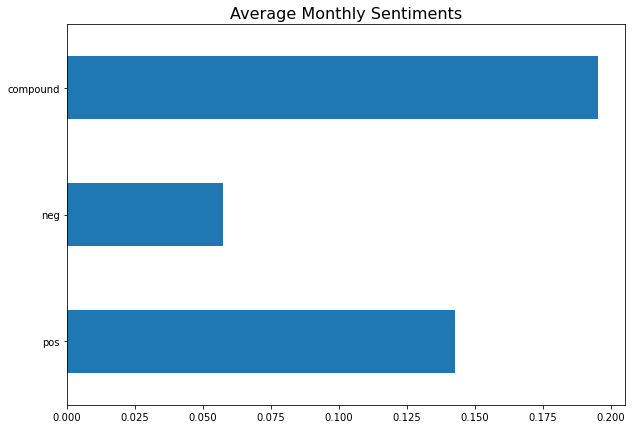

In [46]:
plt.figure(figsize = (10,7))
monthly_sents.mean()[['pos', 'neg', 'compound']].plot(kind='barh')
plt.title('Average Monthly Sentiments', fontsize = 16)
plt.savefig('images/Average Monthly Sentiments');

In [47]:
#computing mean bdc exchange rate per month
monthly_bdc = bdc_rates.resample('M').mean()

In [48]:
#creating column for percentage change in bdc exchange rate
monthly_bdc['bdc_change']= monthly_bdc['bdc'].pct_change()

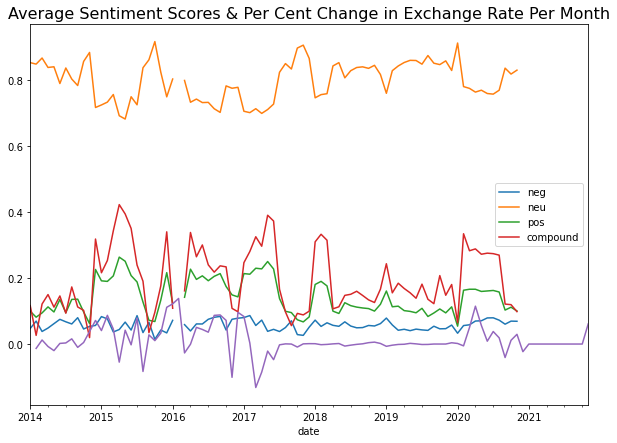

In [49]:
ax = monthly_sents.plot()
monthly_bdc['bdc_change'].plot(ax=ax)
plt.title('Average Sentiment Scores & Per Cent Change in Exchange Rate Per Month', fontsize = 16)
plt.gcf().set_size_inches(10,7)
ax.axes.xaxis.set_visible(True)
plt.savefig('images/Plot of Monthly Sentiments & Average Change in Exchange Rate');


In [50]:
#generate mean sentiment scores for each day in the dataframe
daily_sents = naira_tweets_sent.resample('D').mean()
daily_sents.shape

(2526, 4)

In [51]:
#checking for nulls
daily_sents.isnull().sum()

neg         119
neu         119
pos         119
compound    119
dtype: int64

In [52]:
#checking dimensions
daily_sents.shape, bdc_rates.shape

((2526, 4), (1732, 2))

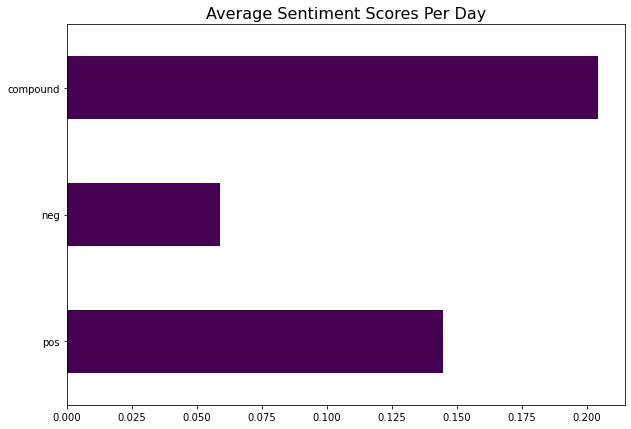

In [53]:
plt.figure(figsize = (10,7))
daily_sents.mean()[['pos', 'neg', 'compound']].plot(kind='barh', cmap = 'viridis')
plt.title('Average Sentiment Scores Per Day', fontsize = 16)
plt.savefig('images/Average DailySentiments');

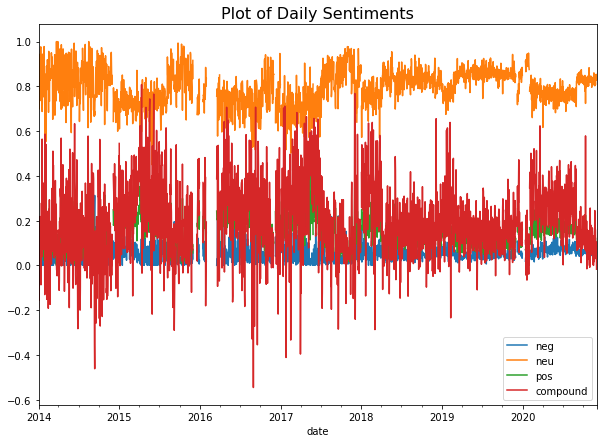

In [65]:
daily_sents.plot()
plt.title('Plot of Daily Sentiments', fontsize = 16)
plt.gcf().set_size_inches(10,7)
plt.savefig('data/Plot of Daily Sentiments');

Daily exchange rate data excluded weekends and public holidays, hence we will merge (left join) with sentiment dataframe which is more representative of the entire time period analyzed.

In [55]:
df = daily_sents.join(bdc_rates)
df.head()

,neg,neu,pos,compound,nominal,bdc
date,,,,,,
2014-01-01,0.208167,0.720500,0.071167,-0.188100,NaN,NaN
2014-01-02,0.026113,0.944050,0.029843,0.015256,157.26,172.0
2014-01-03,0.140405,0.698167,0.161714,0.046255,157.26,172.0
2014-01-04,0.130111,0.797444,0.072444,-0.154944,NaN,NaN
2014-01-05,0.074286,0.763714,0.162000,0.167800,NaN,NaN


In [56]:
df.isnull().sum()

neg         119
neu         119
pos         119
compound    119
nominal     819
bdc         819
dtype: int64

In [57]:
#saving data with nulls to csv to be used for SARIMAX model
df.to_csv('data/df_with_nulls.csv')

In [58]:
#compute mean for each column
df.mean()

neg           0.058822
neu           0.796696
pos           0.144481
compound      0.204178
nominal     267.484467
bdc         329.142465
dtype: float64

In [59]:
#fill nulls in sentiments scores with mean of corresponding columns
df['neg'].fillna(0.058822, inplace = True)
df['neu'].fillna(0.796696, inplace = True)
df['pos'].fillna(0.144481, inplace = True)
df['compound'].fillna(0.204178, inplace = True)

In [60]:
#filling nulls in exchange rate columns with last known values.
df['nominal'].fillna(method = 'ffill', inplace = True)
df['bdc'].fillna(method = 'ffill', inplace = True)
df.isnull().sum()

neg         0
neu         0
pos         0
compound    0
nominal     1
bdc         1
dtype: int64

This approach to filling nulls is based on the assumption that the majority of nulls in exchange rate data 
were caused by weekends and bank holidays.

In [61]:
#filling nulls on new year day, 2014 with the next known value
df['nominal'].fillna(method = 'bfill', inplace = True)
df['bdc'].fillna(method = 'bfill', inplace = True)
df.isnull().sum()

neg         0
neu         0
pos         0
compound    0
nominal     0
bdc         0
dtype: int64

In [62]:
df.shape

(2527, 6)

In [63]:
#saving dataframe as as csv file
df.to_csv('data/final_df.csv')